**Chapter 17 – Autoencoders and GANs**

_This notebook contains all the sample code in chapter 17._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#if not tf.config.list_physical_devices('GPU'):
#    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
#    if IS_COLAB:
#        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale 28x28 image:

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [ ]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Now let's build the Autoencoder...

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 1s 12ms/sample - loss: 0.2561
Epoch 2/20
60/60 [==============================] - 0s 70us/sample - loss: 0.1258
Epoch 3/20
60/60 [==============================] - 0s 99us/sample - loss: 0.2229
Epoch 4/20
60/60 [==============================] - 0s 76us/sample - loss: 0.1502
Epoch 5/20
60/60 [==============================] - 0s 70us/sample - loss: 0.0436
Epoch 6/20
60/60 [==============================] - 0s 91us/sample - loss: 0.0401
Epoch 7/20
60/60 [==============================] - 0s 72us/sample - loss: 0.0344
Epoch 8/20
60/60 [==============================] - 0s 80us/sample - loss: 0.0195
Epoch 9/20
60/60 [==============================] - 0s 103us/sample - loss: 0.0124
Epoch 10/20
60/60 [==============================] - 0s 72us/sample - loss: 0.0096
Epoch 11/20
60/60 [==============================] - 0s 71us/sample - loss: 0.0093
Epoch 12/20
60/60 [==============================] - 0s 106us/sample - loss

In [ ]:
codings = encoder.predict(X_train)

In [ ]:
codings[:5,:]

array([[-1.4531302 , -0.06266931],
       [ 0.21125126,  0.2415598 ],
       [-1.3380544 , -0.03722873],
       [-0.93644756,  0.5581124 ],
       [-0.8672459 ,  0.52012867]], dtype=float32)

Saving figure linear_autoencoder_pca_plot


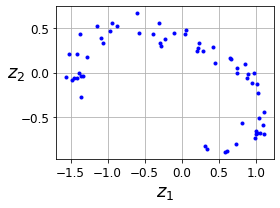

In [ ]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train[0].shape

(28, 28)

## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(50, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 23s 415us/sample - loss: 0.3392 - rounded_accuracy: 0.8848 - val_loss: 0.3117 - val_rounded_accuracy: 0.9112
Epoch 2/20
55000/55000 [==============================] - 24s 445us/sample - loss: 0.3064 - rounded_accuracy: 0.9138 - val_loss: 0.3031 - val_rounded_accuracy: 0.9185
Epoch 3/20
55000/55000 [==============================] - 23s 418us/sample - loss: 0.2993 - rounded_accuracy: 0.9203 - val_loss: 0.2974 - val_rounded_accuracy: 0.9221
Epoch 4/20
55000/55000 [==============================] - 23s 426us/sample - loss: 0.2951 - rounded_accuracy: 0.9241 - val_loss: 0.2951 - val_rounded_accuracy: 0.9223
Epoch 5/20
55000/55000 [==============================] - 23s 427us/sample - loss: 0.2920 - rounded_accuracy: 0.9270 - val_loss: 0.2942 - val_rounded_accuracy: 0.9213
Epoch 6/20
55000/55000 [==============================] - 23s 422us/sample - loss: 0.2900 - rounded_accuracy: 0.9287

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


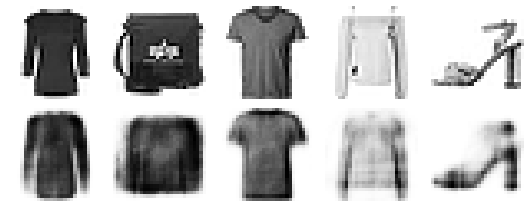

In [ ]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

Saving figure reconstruction_plot


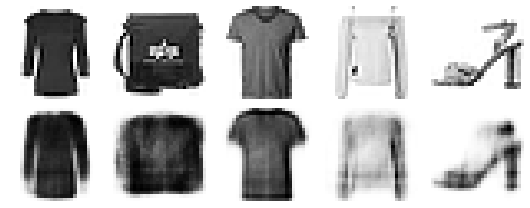

In [ ]:
## + 1 layer 
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

# Visualizing Fashion MNIST

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

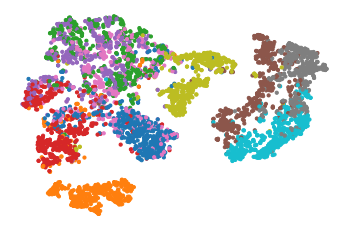

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

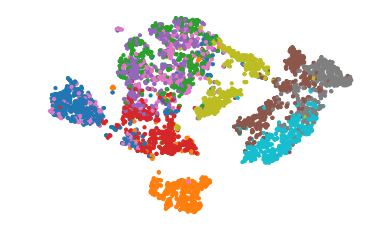

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

Saving figure fashion_mnist_visualization_plot


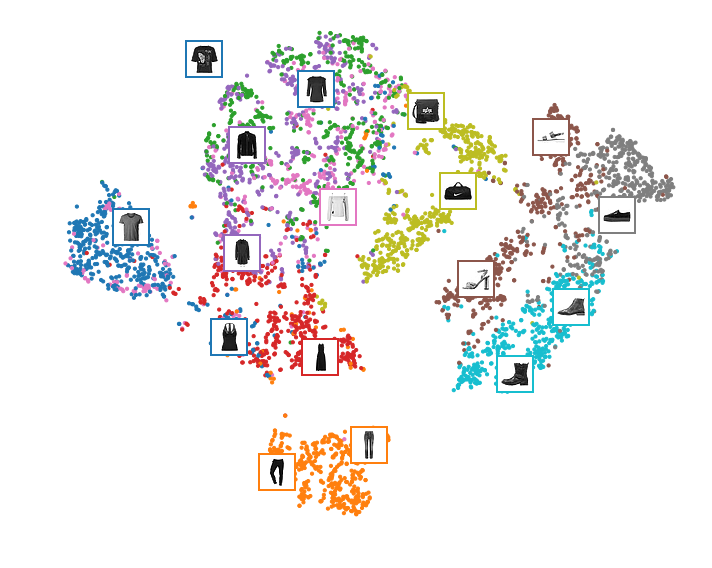

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3213 - rounded_accuracy: 0.8996 - val_loss: 0.3038 - val_rounded_accuracy: 0.9154
Epoch 2/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.2967 - rounded_accuracy: 0.9216 - val_loss: 0.2931 - val_rounded_accuracy: 0.9268
Epoch 3/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2916 - rounded_accuracy: 0.9263 - val_loss: 0.2929 - val_rounded_accuracy: 0.9254
Epoch 4/10
55000/55000 [==============================] - 4s 64us/sample - loss: 0.2889 - rounded_accuracy: 0.9287 - val_loss: 0.2905 - val_rounded_accuracy: 0.9316
Epoch 5/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2871 - rounded_accuracy: 0.9303 - val_loss: 0.2917 - val_rounded_accuracy: 0.9307
Epoch 6/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2858 - rounded_accuracy: 0.9316 - val_loss:

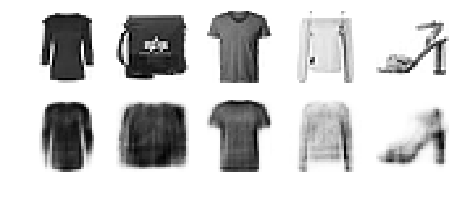

In [ ]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

In [ ]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3446 - rounded_accuracy: 0.8874 - val_loss: 0.3122 - val_rounded_accuracy: 0.9147
Epoch 2/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3039 - rounded_accuracy: 0.9204 - val_loss: 0.3006 - val_rounded_accuracy: 0.9241
Epoch 3/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2933 - val_rounded_accuracy: 0.9319
Epoch 4/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2890 - rounded_accuracy: 0.9343 - val_loss: 0.2887 - val_rounded_accuracy: 0.9362
Epoch 5/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2853 - rounded_accuracy: 0.9379 - val_loss: 0.2856 - val_rounded_accuracy: 0.9390
Epoch 6/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.2826 - rounded_accuracy: 0.9404 - val_loss:

In [ ]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

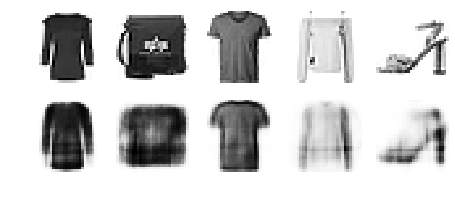

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [ ]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.2853 - rounded_accuracy: 0.9359 - val_loss: 0.2868 - val_rounded_accuracy: 0.9361
Epoch 2/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2849 - rounded_accuracy: 0.9363 - val_loss: 0.2866 - val_rounded_accuracy: 0.9364
Epoch 3/10
55000/55000 [==============================] - 4s 66us/sample - loss: 0.2847 - rounded_accuracy: 0.9365 - val_loss: 0.2864 - val_rounded_accuracy: 0.9362
Epoch 4/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2846 - rounded_accuracy: 0.9366 - val_loss: 0.2863 - val_rounded_accuracy: 0.9367
Epoch 5/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.2844 - rounded_accuracy: 0.9368 - val_loss: 0.2862 - val_rounded_accuracy: 0.9369
Epoch 6/10
55000/55000 [==============================] - 4s 66us/sample - loss: 0.2843 - rounded_accuracy: 0.9369 - val_loss:

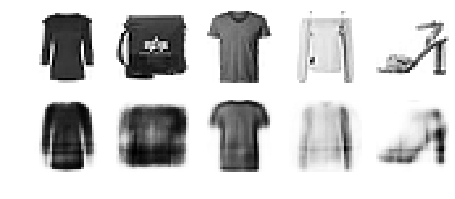

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 40s 734us/sample - loss: 0.3017 - accuracy: 0.5064 - val_loss: 0.2842 - val_accuracy: 0.5058
Epoch 2/5
55000/55000 [==============================] - 39s 712us/sample - loss: 0.2756 - accuracy: 0.5088 - val_loss: 0.2739 - val_accuracy: 0.5058
Epoch 3/5
55000/55000 [==============================] - 39s 715us/sample - loss: 0.2709 - accuracy: 0.5092 - val_loss: 0.2720 - val_accuracy: 0.5059
Epoch 4/5
55000/55000 [==============================] - 39s 707us/sample - loss: 0.2682 - accuracy: 0.5094 - val_loss: 0.2685 - val_accuracy: 0.5063
Epoch 5/5
55000/55000 [==============================] - 39s 706us/sample - loss: 0.2665 - accuracy: 0.5095 - val_loss: 0.2671 - val_accuracy: 0.5066


In [ ]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

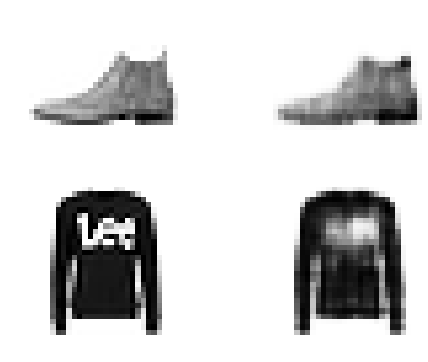

In [ ]:
show_reconstructions(conv_ae)
plt.show()

# Recurrent Autoencoders

In [ ]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [ ]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 79s 1ms/sample - loss: 0.5165 - rounded_accuracy: 0.7363 - val_loss: 0.4489 - val_rounded_accuracy: 0.8137
Epoch 2/10
55000/55000 [==============================] - 78s 1ms/sample - loss: 0.4049 - rounded_accuracy: 0.8415 - val_loss: 0.3762 - val_rounded_accuracy: 0.8650
Epoch 3/10
55000/55000 [==============================] - 80s 1ms/sample - loss: 0.3662 - rounded_accuracy: 0.8703 - val_loss: 0.3626 - val_rounded_accuracy: 0.8730
Epoch 4/10
55000/55000 [==============================] - 80s 1ms/sample - loss: 0.3505 - rounded_accuracy: 0.8808 - val_loss: 0.3483 - val_rounded_accuracy: 0.8838
Epoch 5/10
55000/55000 [==============================] - 82s 1ms/sample - loss: 0.3398 - rounded_accuracy: 0.8881 - val_loss: 0.3345 - val_rounded_accuracy: 0.8941
Epoch 6/10
55000/55000 [==============================] - 93s 2ms/sample - loss: 0.3328 - rounded_accuracy: 0.8930 - val_loss:

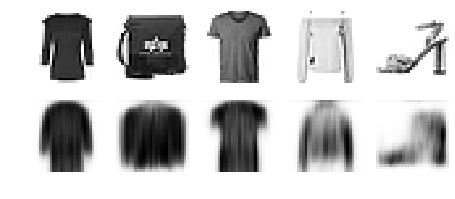

In [ ]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder

Using Gaussian noise:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.3508 - rounded_accuracy: 0.8768 - val_loss: 0.3231 - val_rounded_accuracy: 0.9065
Epoch 2/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3125 - rounded_accuracy: 0.9093 - val_loss: 0.3077 - val_rounded_accuracy: 0.9153
Epoch 3/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3061 - rounded_accuracy: 0.9149 - val_loss: 0.3034 - val_rounded_accuracy: 0.9190
Epoch 4/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3025 - rounded_accuracy: 0.9181 - val_loss: 0.3007 - val_rounded_accuracy: 0.9195
Epoch 5/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2980 - val_rounded_accuracy: 0.9230
Epoch 6/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.2979 - rounded_accuracy: 0.9220 - val_loss:

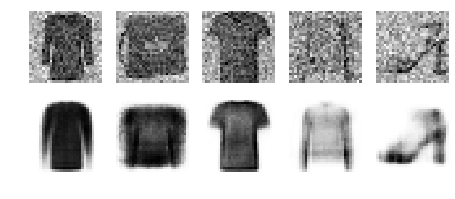

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3564 - accuracy: 0.4969 - val_loss: 0.3206 - val_accuracy: 0.5011
Epoch 2/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3182 - accuracy: 0.5034 - val_loss: 0.3113 - val_accuracy: 0.5014
Epoch 3/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3130 - accuracy: 0.5042 - val_loss: 0.3079 - val_accuracy: 0.5012
Epoch 4/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3091 - accuracy: 0.5048 - val_loss: 0.3037 - val_accuracy: 0.5026
Epoch 5/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3066 - accuracy: 0.5052 - val_loss: 0.3032 - val_accuracy: 0.5016
Epoch 6/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3047 - accuracy: 0.5054 - val_loss: 0.3001 - val_accuracy: 0.5032
Epoch 7/10
55000/55000 [==============================] -

Saving figure dropout_denoising_plot


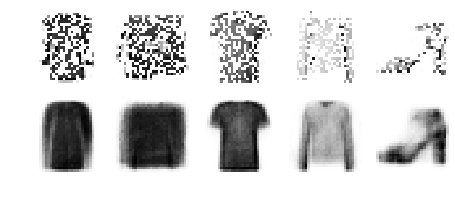

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# Sparse Autoencoder

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.), metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 23s 411us/sample - loss: 0.4326 - rounded_accuracy: 0.7948 - val_loss: 0.3773 - val_rounded_accuracy: 0.8503
Epoch 2/10
55000/55000 [==============================] - 24s 440us/sample - loss: 0.3610 - rounded_accuracy: 0.8670 - val_loss: 0.3508 - val_rounded_accuracy: 0.8783
Epoch 3/10
55000/55000 [==============================] - 24s 445us/sample - loss: 0.3402 - rounded_accuracy: 0.8861 - val_loss: 0.3359 - val_rounded_accuracy: 0.8873
Epoch 4/10
55000/55000 [==============================] - 23s 412us/sample - loss: 0.3273 - rounded_accuracy: 0.8968 - val_loss: 0.3248 - val_rounded_accuracy: 0.9007
Epoch 5/10
55000/55000 [==============================] - 23s 423us/sample - loss: 0.3207 - rounded_accuracy: 0.9016 - val_loss: 0.3211 - val_rounded_accuracy: 0.9047
Epoch 6/10
55000/55000 [==============================] - 24s 443us/sample - loss: 0.3173 - rounded_accuracy: 0.9041

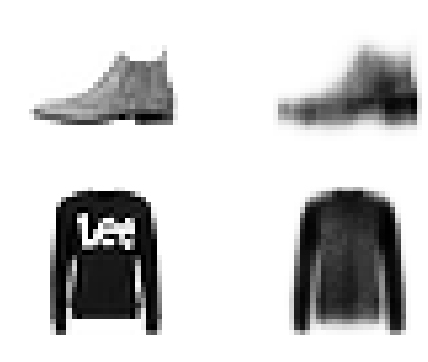

In [ ]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [ ]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

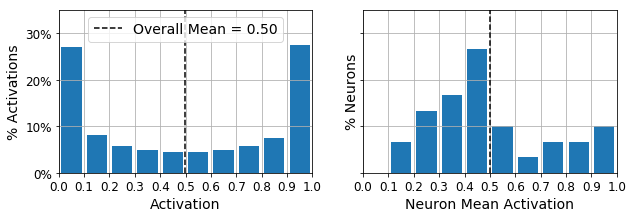

In [ ]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add $\ell_1$ regularization to the coding layer:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.4306 - accuracy: 0.4947 - val_loss: 0.3819 - val_accuracy: 0.4897
Epoch 2/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3689 - accuracy: 0.4971 - val_loss: 0.3639 - val_accuracy: 0.4940
Epoch 3/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3553 - accuracy: 0.4987 - val_loss: 0.3513 - val_accuracy: 0.4970
Epoch 4/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3443 - accuracy: 0.5003 - val_loss: 0.3428 - val_accuracy: 0.4964
Epoch 5/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3379 - accuracy: 0.5009 - val_loss: 0.3372 - val_accuracy: 0.4979
Epoch 6/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3332 - accuracy: 0.5015 - val_loss: 0.3329 - val_accuracy: 0.4980
Epoch 7/10
55000/55000 [==============================] -

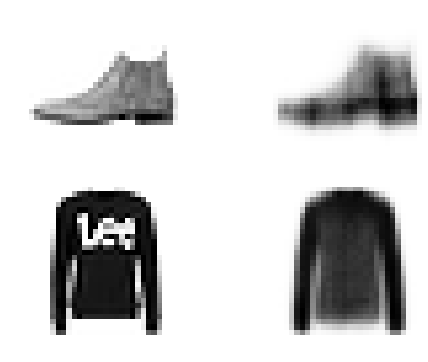

In [ ]:
show_reconstructions(sparse_l1_ae)

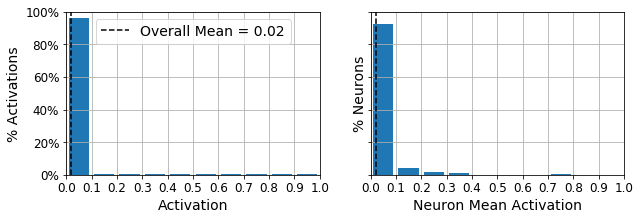

In [ ]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

Saving figure sparsity_loss_plot


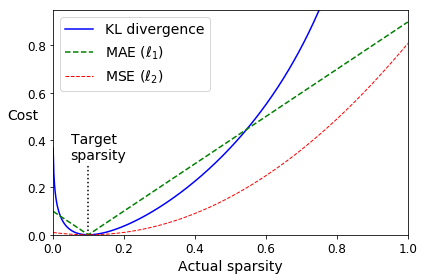

In [ ]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.4151 - rounded_accuracy: 0.8121 - val_loss: 0.3714 - val_rounded_accuracy: 0.8560
Epoch 2/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.3532 - rounded_accuracy: 0.8762 - val_loss: 0.3442 - val_rounded_accuracy: 0.8842
Epoch 3/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3340 - rounded_accuracy: 0.8919 - val_loss: 0.3292 - val_rounded_accuracy: 0.8976
Epoch 4/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9040
Epoch 5/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.3170 - rounded_accuracy: 0.9062 - val_loss: 0.3170 - val_rounded_accuracy: 0.9075
Epoch 6/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.3134 - rounded_accuracy: 0.9093 - val_loss

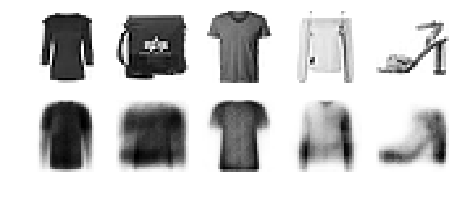

In [ ]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


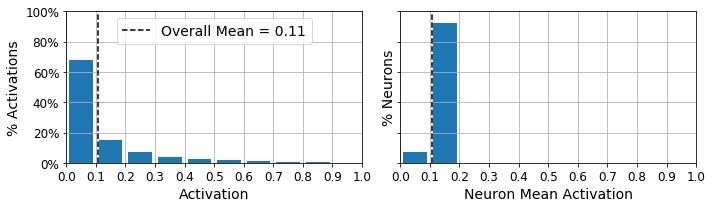

In [ ]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# Variational Autoencoder

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 84us/sample - loss: 0.3889 - rounded_accuracy: 0.8608 - val_loss: 0.3592 - val_rounded_accuracy: 0.8840
Epoch 2/25
55000/55000 [==============================] - 3s 60us/sample - loss: 0.3429 - rounded_accuracy: 0.8974 - val_loss: 0.3369 - val_rounded_accuracy: 0.8982
Epoch 3/25
55000/55000 [==============================] - 3s 53us/sample - loss: 0.3329 - rounded_accuracy: 0.9050 - val_loss: 0.3356 - val_rounded_accuracy: 0.9022
Epoch 4/25
55000/55000 [==============================] - 3s 61us/sample - loss: 0.3275 - rounded_accuracy: 0.9092 - val_loss: 0.3255 - val_rounded_accuracy: 0.9105
Epoch 5/25
55000/55000 [==============================] - 3s 59us/sample - loss: 0.3243 - rounded_accuracy: 0.9119 - val_loss: 0.3232 - val_rounded_accuracy: 0.9169
Epoch 6/25
55000/55000 [==============================] - 3s 58us/sample - loss: 0.3219 - rounded_accuracy: 0.9138 - val_loss:

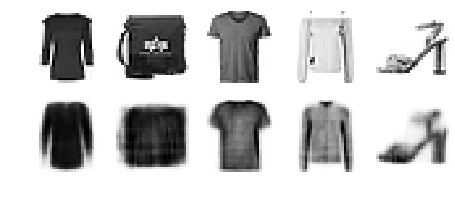

In [ ]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

Saving figure vae_generated_images_plot


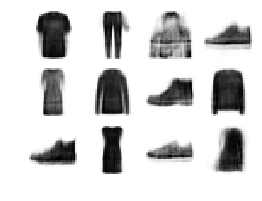

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Now let's perform semantic interpolation between these images:

Saving figure semantic_interpolation_plot


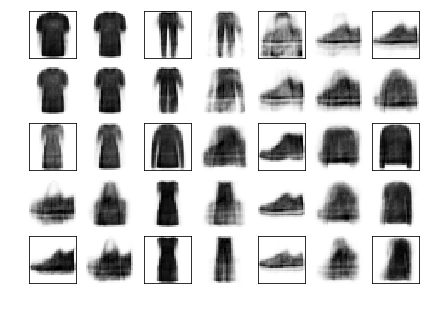

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)